In [1]:
# simple EDA set up

In [2]:
pip install pretty_midi pandas matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import glob
import os
import pretty_midi


In [4]:
import glob, os, pprint

# get all files
root = "/home/s2kunapareddy/music/data/midi"
midi_files = glob.glob(os.path.join(root, "**", "*.midi"), recursive=True)

midi_files = [f for f in midi_files if os.path.isfile(f)]

print(f"Found {len(midi_files):,} MIDI files")
pprint.pp(midi_files[:5])     

Found 1,276 MIDI files
['/home/s2kunapareddy/music/data/midi/2013/ORIG-MIDI_01_7_10_13_Group_MID--AUDIO_07_R3_2013_wav--2.midi',
 '/home/s2kunapareddy/music/data/midi/2013/ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_02_R2_2013_wav--1.midi',
 '/home/s2kunapareddy/music/data/midi/2013/ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_02_R1_2013_wav--2.midi',
 '/home/s2kunapareddy/music/data/midi/2013/ORIG-MIDI_03_7_6_13_Group__MID--AUDIO_09_R1_2013_wav--3.midi',
 '/home/s2kunapareddy/music/data/midi/2013/ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_15_R1_2013_wav--4.midi']


Get midi features 

In [5]:
import pandas as pd
from tqdm import tqdm

rows = []
for path in tqdm(midi_files):
    try:
        pm = pretty_midi.PrettyMIDI(path)
        duration = pm.get_end_time()             # seconds
        n_notes  = sum(len(ins.notes) for ins in pm.instruments)
        tempo_changes, tempi = pm.get_tempo_changes()
        total_velocity = sum(sum(pm.get_chroma()))
        total_force = sum(n.velocity for ins in pm.instruments for n in ins.notes)
        tempo = pm.estimate_tempo()
        mean_tempo = tempi.mean() if len(tempi) else None
        pitches = [n.pitch for ins in pm.instruments for n in ins.notes]

        # duration of notes 
        note_durations = [n.end - n.start for ins in pm.instruments for n in ins.notes]

        # Onsets
        onsets = sorted(n.start for ins in pm.instruments for n in ins.notes)
        
        rows.append({
            "file": path,
            "total_velocity" : total_velocity,
            "duration_s": duration,
            "note_durations": note_durations,
            "onsets" : onsets, 
            "n_notes": n_notes,
            "total_force": total_force,
            "min_pitch": min(pitches) if pitches else None,
            "max_pitch": max(pitches) if pitches else None,
            "temp" : tempo, 
            "mean_tempo": mean_tempo
        })
    except Exception as e:
        print(f"Skip {path}: {e}")

df = pd.DataFrame(rows)

100%|██████████| 1276/1276 [09:47<00:00,  2.17it/s]



Total Velocity: It acts as a proxy for how active or intense the MIDI file is overall:

- Louder (higher velocity) notes → higher total
- Longer durations → higher total
- Sustained or densely packed music = high total_velocity


In [6]:
df.total_velocity.max()

96734567.0

In [7]:
df.total_velocity.min()

569504.0

Total Force: The total MIDI velocity values summed over all notes captures how "forcefully" a piece is played.

In [8]:
df.total_force.max()

1623551

In [9]:
df.total_force.min()

8385

In [10]:
df.total_force.mean()

356919.9913793103

In [11]:
df.min_pitch.unique()

array([29, 30, 21, 28, 38, 22, 26, 36, 25, 37, 33, 31, 24, 35, 27, 34, 32,
       23, 40, 44, 42, 43, 41, 39])

In [12]:
df

,file,total_velocity,duration_s,note_durations,onsets,n_notes,total_force,min_pitch,max_pitch,temp,mean_tempo
0,/home/s2kunapareddy/music/data/midi/2013/ORIG-...,22468353.0,802.019531,"[0.75, 1.65625, 1.7057291666666665, 1.73046874...","[0.9921875, 0.9973958333333333, 1.0, 1.7526041...",7424,488227,29,96,198.720806,120.0
1,/home/s2kunapareddy/music/data/midi/2013/ORIG-...,16376010.0,634.451823,"[0.13671875, 0.26171875, 0.23697916666666674, ...","[0.98046875, 1.0065104166666665, 1.47005208333...",6276,348017,29,101,208.328446,120.0
2,/home/s2kunapareddy/music/data/midi/2013/ORIG-...,6615269.0,325.291667,"[0.10677083333333326, 0.04166666666666652, 0.0...","[0.9921875, 1.01171875, 1.0182291666666665, 1....",3993,271022,30,91,212.297820,120.0
3,/home/s2kunapareddy/music/data/midi/2013/ORIG-...,2531637.0,193.209635,"[0.06510416666666674, 0.046875, 0.098958333333...","[0.9231770833333333, 0.98828125, 1.02864583333...",1832,113098,29,86,209.863370,120.0
4,/home/s2kunapareddy/music/data/midi/2013/ORIG-...,15711958.0,299.591146,"[0.14713541666666674, 0.05208333333333326, 0.0...","[0.7942708333333333, 1.0234375, 1.131510416666...",4637,328644,21,105,214.294434,120.0
...,...,...,...,...,...,...,...,...,...,...,...
1271,/home/s2kunapareddy/music/data/midi/2011/MIDI-...,19444204.0,503.242188,"[2.7669270833333335, 2.786458333333333, 0.6093...","[0.9830729166666666, 0.9921875, 3.272135416666...",4972,311676,26,101,212.255572,120.0
1272,/home/s2kunapareddy/music/data/midi/2011/MIDI-...,15820795.0,354.255208,"[0.3372395833333335, 0.25520833333333326, 0.13...","[1.0377604166666665, 1.4270833333333333, 1.673...",2809,158876,25,104,216.052747,120.0
1273,/home/s2kunapareddy/music/data/midi/2011/MIDI-...,13932892.0,537.532552,"[0.13411458333333326, 0.1640625, 0.17578125, 1...","[0.95703125, 0.96875, 1.0403645833333333, 1.07...",5978,326722,29,101,212.389381,120.0
1274,/home/s2kunapareddy/music/data/midi/2011/MIDI-...,13844226.0,238.141927,"[0.22265625, 0.20182291666666674, 0.3046875, 0...","[0.9921875, 1.0, 1.01171875, 1.020833333333333...",3946,277402,28,98,212.595156,120.0


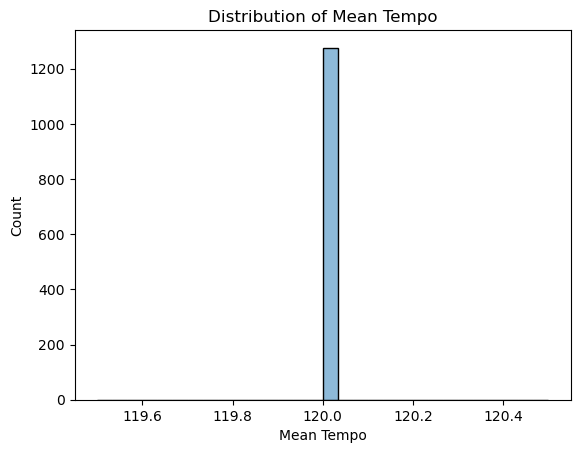

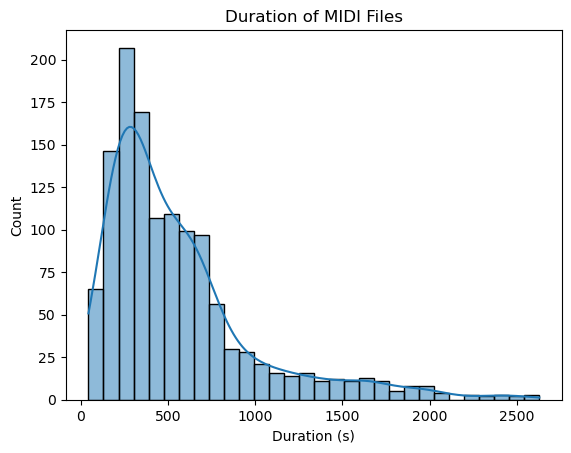

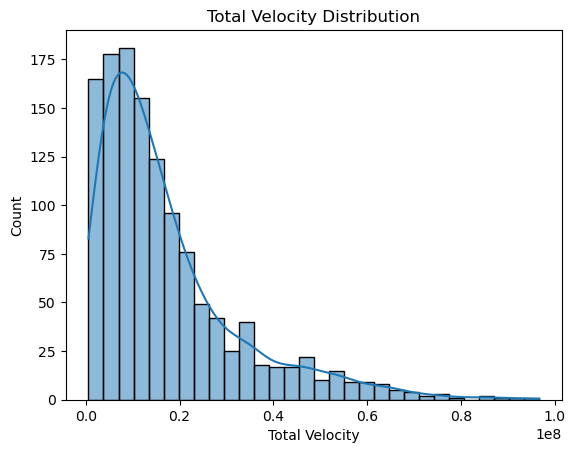

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tempo distribution
sns.histplot(df['mean_tempo'], bins=30, kde=True)
plt.title('Distribution of Mean Tempo')
plt.xlabel('Mean Tempo')
plt.ylabel('Count')
plt.show()

# Duration
sns.histplot(df['duration_s'], bins=30, kde=True)
plt.title('Duration of MIDI Files')
plt.xlabel('Duration (s)')
plt.ylabel('Count')
plt.show()

# Total Velocity
sns.histplot(df['total_velocity'], bins=30, kde=True)
plt.title('Total Velocity Distribution')
plt.xlabel('Total Velocity')
plt.show()


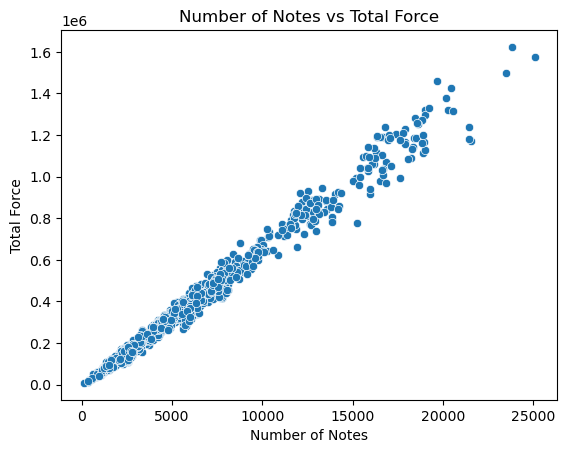

In [14]:
# Force vs Number of Notes
sns.scatterplot(x='n_notes', y='total_force', data=df)
plt.title('Number of Notes vs Total Force')
plt.xlabel('Number of Notes')
plt.ylabel('Total Force')
plt.show()


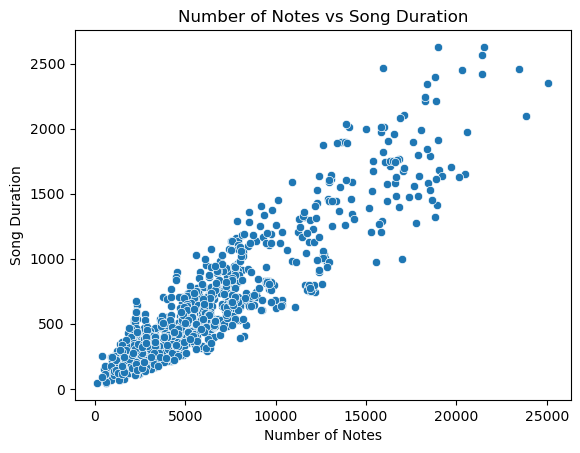

In [15]:
# Duration vs Number of Notes
sns.scatterplot(x='n_notes', y='duration_s', data=df)
plt.title('Number of Notes vs Song Duration')
plt.xlabel('Number of Notes')
plt.ylabel('Song Duration')
plt.show()

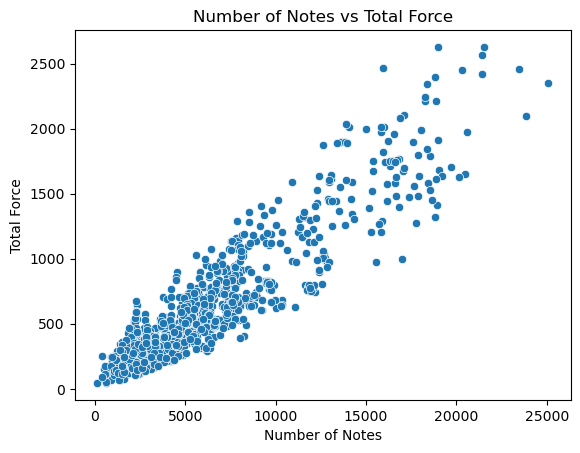

In [16]:
# Duration vs Number of Notes
sns.scatterplot(x='n_notes', y='duration_s', data=df)
plt.title('Number of Notes vs Total Force')
plt.xlabel('Number of Notes')
plt.ylabel('Total Force')
plt.show()

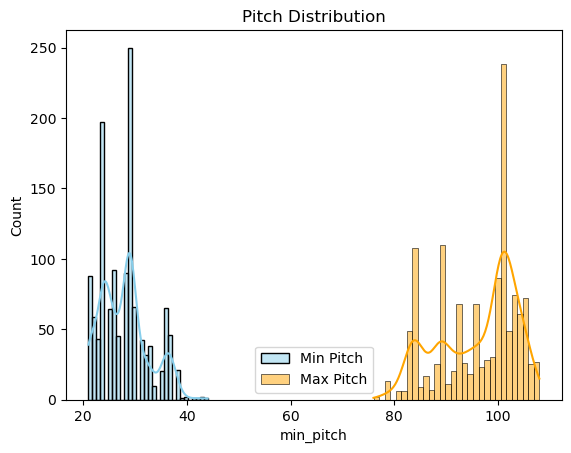

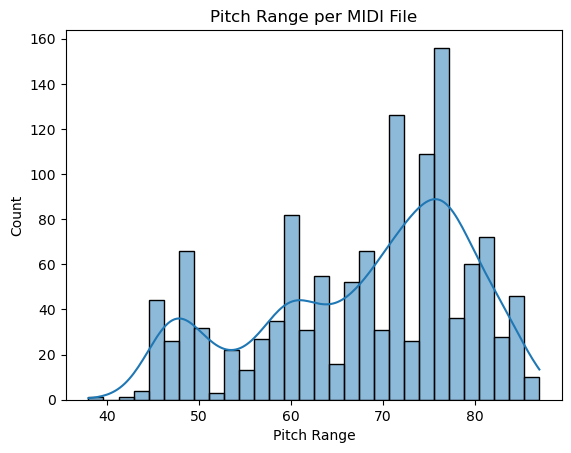

In [17]:
# Min vs Max Pitch
sns.histplot(df['min_pitch'], bins=30, kde=True, color='skyblue', label='Min Pitch')
sns.histplot(df['max_pitch'], bins=30, kde=True, color='orange', label='Max Pitch')
plt.legend()
plt.title('Pitch Distribution')
plt.show()

# Pitch Range
df['pitch_range'] = df['max_pitch'] - df['min_pitch']
sns.histplot(df['pitch_range'], bins=30, kde=True)
plt.title('Pitch Range per MIDI File')
plt.xlabel('Pitch Range')
plt.show()


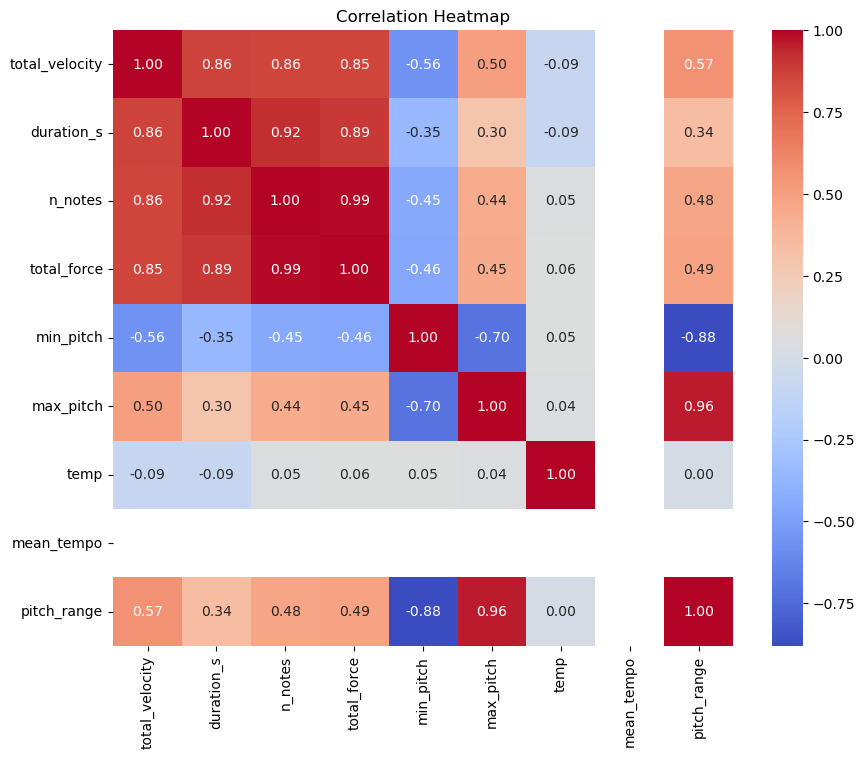

In [18]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

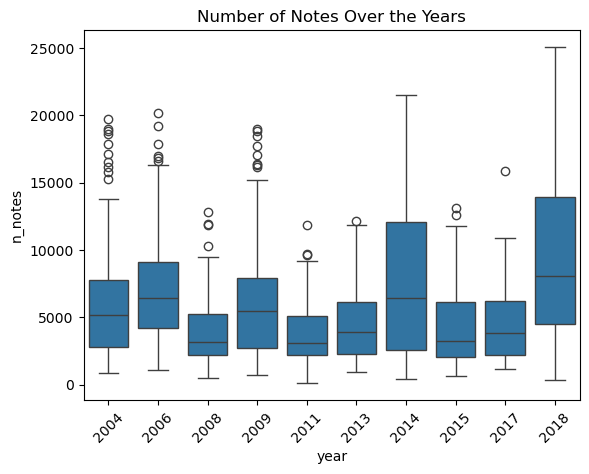

In [19]:
df['year'] = df['file'].str.extract(r'(\d{4})').astype(int)

# Notes over the years
sns.boxplot(x='year', y='n_notes', data=df)
plt.title('Number of Notes Over the Years')
plt.xticks(rotation=45)
plt.show()

In [36]:
import os
import pandas as pd

# --- 1. Read the MAESTRO metadata ------------------------------------------
meta_csv = "/home/s2kunapareddy/music/data/midi/maestro-v3.0.0.csv"  
meta     = pd.read_csv(meta_csv)

# The CSV stores the MIDI path *relative* to the `midi/` directory, e.g.
#   midi_filename -> "2013/ORIG-MIDI_01_7_10_13_Group_MID--AUDIO_07_R3_2013_wav--2.midi"
# Build a column that matches your absolute paths:
root = "/home/s2kunapareddy/music/data/midi"
meta["file"] = meta["midi_filename"].apply(lambda x: os.path.normpath(os.path.join(root, x)))

# Keep only what you need (optional)
meta = meta[["file",              # absolute path (same key as df["file"])
             "canonical_composer",# standardized spelling   (e.g. "Frédéric Chopin")
             "canonical_title",
             "year"]]
meta

,file,canonical_composer,canonical_title,year
0,/home/s2kunapareddy/music/data/midi/2018/MIDI-...,Alban Berg,Sonata Op. 1,2018
1,/home/s2kunapareddy/music/data/midi/2008/MIDI-...,Alban Berg,Sonata Op. 1,2008
2,/home/s2kunapareddy/music/data/midi/2017/MIDI-...,Alban Berg,Sonata Op. 1,2017
3,/home/s2kunapareddy/music/data/midi/2004/MIDI-...,Alexander Scriabin,"24 Preludes Op. 11, No. 13-24",2004
4,/home/s2kunapareddy/music/data/midi/2006/MIDI-...,Alexander Scriabin,"3 Etudes, Op. 65",2006
...,...,...,...,...
1271,/home/s2kunapareddy/music/data/midi/2004/MIDI-...,Wolfgang Amadeus Mozart,"Sonata in F Major, K280",2004
1272,/home/s2kunapareddy/music/data/midi/2004/MIDI-...,Wolfgang Amadeus Mozart,"Sonata in F Major, K280",2004
1273,/home/s2kunapareddy/music/data/midi/2004/MIDI-...,Wolfgang Amadeus Mozart,"Sonata in F Major, K533",2004
1274,/home/s2kunapareddy/music/data/midi/2018/MIDI-...,Wolfgang Amadeus Mozart,"Sonata in F Major, K533/K494",2018


In [39]:
meta.canonical_composer.value_counts()

canonical_composer
Frédéric Chopin                                       201
Franz Schubert                                        186
Ludwig van Beethoven                                  146
Johann Sebastian Bach                                 145
Franz Liszt                                           131
Sergei Rachmaninoff                                    59
Robert Schumann                                        49
Claude Debussy                                         45
Joseph Haydn                                           40
Wolfgang Amadeus Mozart                                38
Alexander Scriabin                                     35
Domenico Scarlatti                                     31
Felix Mendelssohn                                      28
Johannes Brahms                                        26
Franz Schubert / Franz Liszt                           10
Isaac Albéniz                                           7
Muzio Clementi                                       

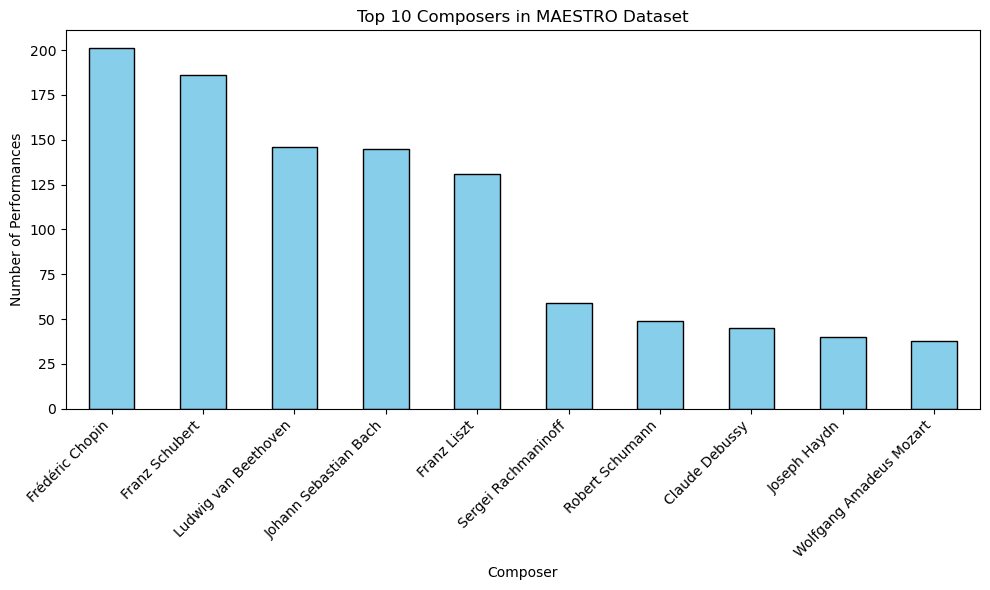

In [40]:
import matplotlib.pyplot as plt

# Count number of pieces per composer
composer_counts = meta['canonical_composer'].value_counts().head(10)

# Plot
plt.figure(figsize=(10, 6))
composer_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 10 Composers in MAESTRO Dataset')
plt.xlabel('Composer')
plt.ylabel('Number of Performances')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [42]:
# HI